In [33]:
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
from scipy.cluster.hierarchy import linkage,dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
%matplotlib inline
import os

import scipy.optimize as sco

from scipy.linalg import block_diag
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

In [34]:
filenames=[i for i in os.listdir('./BK') if i.endswith('.csv')]
filenames

['BTC.csv', 'ETH.csv', 'link.csv', 'ltc.csv', 'USDT.csv', 'XRP.csv']

In [35]:
data=None
for f in filenames:
    one_data=pd.read_csv('BK/'+f)
    one_data=one_data.iloc[:,7:]
    one_data.columns=[i.split('.')[-1] for i in one_data.columns]
    one_data=one_data[['time','close']]
    one_data=one_data.rename(columns={'close':f.split('.')[0]})
#     break
    if data is None:
        data=one_data
    else:
        data=data.merge(one_data,on=['time'])

In [36]:
data=data.set_index('time')
data=data.pct_change()

In [37]:
data.index=pd.to_datetime(data.index)
data=data.replace(np.inf,np.nan).replace(-np.inf,np.nan)
data.index.name='DT'

In [38]:
def calc_return(df, pct_col='pct_chg'):

    df = df.sort_values(by='DT')
    r = (df[pct_col] + 1).cumprod().iloc[-1] - 1
    return r


def calc_yearly_ret(df, pct_col='pct_chg', freq='D'):

    freq = freq.lower()
    df = df.sort_values(by='DT')
    r = (df[pct_col] + 1).cumprod().iloc[-1] - 1
    if freq == 'd':
        add_days = 1
    elif freq == 'w':
        add_days = 7
    elif freq == 'm':
        add_days = 30
    else:
        raise Exception('周期只能为日、周、月')
    time_range = ((df.DT.max() - df.DT.min()).days + add_days) / 365
    return np.power((r + 1), 1 / time_range) - 1


def calc_yearly_vol(df, pct_col='pct_chg', freq='D'):

    freq = freq.lower()
    if freq == 'd':
        trade_num = 250
    elif freq == 'w':
        trade_num = 50
    elif freq == 'm':
        trade_num = 12
    else:
        raise Exception('周期只能为日、周、月')
    # print(df)
    return df[pct_col].std() * np.sqrt((trade_num))


def calc_sharp(df, pct_col='pct_chg', freq='D'):
 
    yearly_r = calc_yearly_ret(df, pct_col, freq)
    yearly_vol = calc_yearly_vol(df, pct_col, freq)
    sharp = yearly_r / yearly_vol
    return sharp


def calc_maxdrawdown(df, pct_col='pct_chg'):

    df['net']=(df[pct_col]+1).cumprod()
    max_drawdown = (df['net'] / df['net'].expanding().max() - 1).min()
    return max_drawdown

def calc_var(df,pct_col='pct_chg'):
    miu=df[pct_col].mean()
    std=df[pct_col].std()
    return abs(miu-1.65*std)
    
    
def calc_sta(pct_df):
    cols=pct_df.columns[1:]
    
    sta_df=pd.DataFrame(columns=['Cumulative Return','Yearly Return','Yearly Volatility','Sharpe Ratio','Maximum Drawdown','VaR'],dtype=np.float64)
    for i in cols:
        ret=calc_return(pct_df,i)
        ret_yearly=calc_yearly_ret(pct_df,i)
        vol=calc_yearly_vol(pct_df,i)
        sharp=calc_sharp(pct_df,i)
        mdd=calc_maxdrawdown(pct_df,i)
        var=calc_var(pct_df,i)
        sta_df.loc[i]=[ret,ret_yearly,vol,sharp,mdd,var]
        
    return sta_df

In [39]:
def calc_w_max_sharp(data):
    n=data.shape[1]
    ret=data.mean(axis=0)
    cov=data.cov()
        
    def stats(weights):
        weights = np.array(weights)
        port_returns = np.sum(ret*weights)*244
        port_variance = np.sqrt(np.dot(weights.T, np.dot(cov*244,weights)))
        return np.array([port_returns, port_variance, port_returns/port_variance])

    def min_sharpe(weights):
        return -stats(weights)[2]

    x0 = n*[1./n]

    bnds = tuple((0.05,1) for x in range(n))

    cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
           
    opts = sco.minimize(min_sharpe,
                        x0, 
                        method = 'SLSQP', 
                        bounds = bnds, 
                        constraints = cons)
    return opts.x

def calc_w_min_variance(data):
    n=data.shape[1]
    ret=data.mean(axis=0)
    cov=data.cov()
        
    def stats(weights):
        weights = np.array(weights)
        port_returns = np.sum(ret*weights)*244
        port_variance = np.sqrt(np.dot(weights.T, np.dot(cov*244,weights)))
        return np.array([port_returns, port_variance, port_returns/port_variance])

    def min_sharpe(weights):
        return stats(weights)[1]

    x0 = n*[1./n]

    bnds = tuple((0.05,1) for x in range(n))

    cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
           
    opts = sco.minimize(min_sharpe,
                        x0, 
                        method = 'SLSQP', 
                        bounds = bnds, 
                        constraints = cons)
    return opts.x

In [40]:

def seriation(Z, N, cur_index):
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

def compute_serial_matrix(dist_mat, method="ward"):
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage    

def compute_HRP_weights(covariances, res_order):
    weights = pd.Series([1]*len(res_order), index=res_order)
    clustered_alphas = [res_order]

    while len(clustered_alphas) > 0:
        clustered_alphas = [cluster[start:end] for cluster in clustered_alphas
                            for start, end in ((0, len(cluster) // 2),
                                               (len(cluster) // 2, len(cluster)))
                            if len(cluster) > 1]
        for subcluster in range(0, len(clustered_alphas), 2):
            left_cluster = clustered_alphas[subcluster]
            right_cluster = clustered_alphas[subcluster + 1]

            left_subcovar = covariances[left_cluster].loc[left_cluster]
            inv_diag = 1 / np.diag(left_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

            right_subcovar = covariances[right_cluster].loc[right_cluster]
            inv_diag = 1 / np.diag(right_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

            alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)

            weights[left_cluster] *= alloc_factor
            weights[right_cluster] *= 1 - alloc_factor
            
    return weights

In [43]:
estimate_correl=data.dropna().corr()
estimate_covar=data.dropna().cov()
distances = np.sqrt((1 - estimate_correl) / 2)
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(distances.values, method='single')
estimate_covar.columns=range(6)
estimate_covar.index=range(6)
hrp_weight=compute_HRP_weights(estimate_covar,res_order).values

1

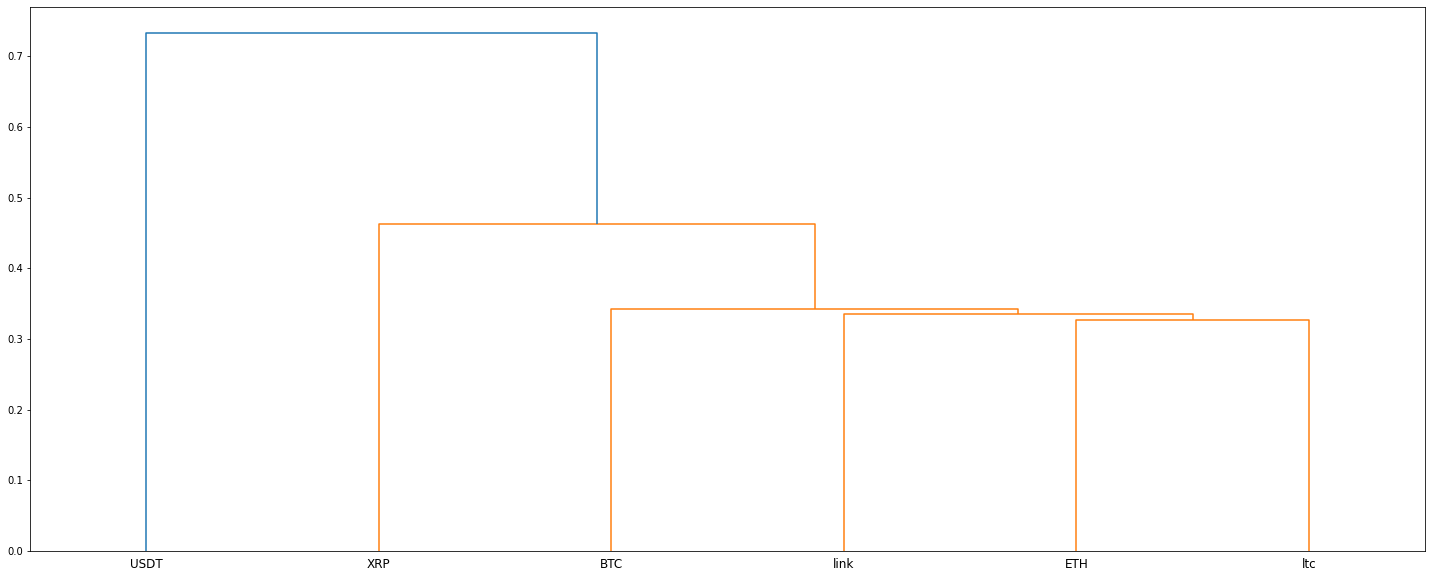

In [44]:
plt.figure(figsize=(25,10))
flt_dis=squareform(distances)
res_linkage=linkage(flt_dis,'single')
dendrogram(res_linkage,labels=distances.index)
1

In [45]:
max_sharp_weight=calc_w_max_sharp(data.dropna())
min_variance_weight=calc_w_min_variance(data.dropna())
equal_weight=np.array([1/data.shape[1]]*data.shape[1])

In [76]:
bnb=pd.read_excel('./BK/bnb.xlsx')
tether=pd.read_excel('./BK/tether.xlsx')

In [77]:
bnb=bnb[['Date','Close**']].sort_values(by='Date')
bnb.columns=['DT','BNB']
bnb=bnb.set_index('DT')
tether=tether[['Date','Close**']].sort_values(by='Date')
tether.columns=['DT','tether']
tether=tether.set_index('DT')
CRIX=data[['BTC','ETH','USDT']].merge(bnb.merge(tether,left_index=True,right_index=True).pct_change(),left_index=True,right_index=True)
crix_weight=np.array([0.6266,0.2415,0.0256,0.0458,0.0604])
CRIX=pd.DataFrame((CRIX*crix_weight).sum(axis=1),columns=['CRIX']).reset_index()

In [78]:
max_sharp_portfolio=pd.DataFrame((data*max_sharp_weight).sum(axis=1),columns=['max_sharp']).reset_index()
min_variance_portfolio=pd.DataFrame((data*min_variance_weight).sum(axis=1),columns=['min_variance']).reset_index()
equal_portfolio=pd.DataFrame((data*equal_weight).sum(axis=1),columns=['euqal_weight']).reset_index()
hrp_portfolio=pd.DataFrame((data*hrp_weight).sum(axis=1),columns=['hrp_weight']).reset_index()

In [81]:
hrp_weight

array([9.99196710e-01, 8.88087988e-05, 4.30319396e-04, 1.01176405e-04,
       1.00377466e-04, 8.26082295e-05])

In [79]:
ret_data=max_sharp_portfolio.merge(min_variance_portfolio,on=['DT']).merge(equal_portfolio,on=['DT']).merge(hrp_portfolio,on=['DT']).merge(CRIX,on=['DT'])

In [80]:
calc_sta(ret_data)

,累计收益,年化收益,年化波动,夏普比率,最大回撤,VaR
max_sharp,8.363792,6.507682,0.735335,8.849960,-0.544225,0.070106
min_variance,0.771255,0.674016,0.204871,3.289945,-0.188250,0.019883
euqal_weight,4.103266,3.344475,0.686726,4.870173,-0.550288,0.066676
hrp_weight,4.084703,3.330230,0.623237,5.343439,-0.530781,0.060244
CRIX,5.768956,4.603958,0.595224,7.734835,-0.469080,0.056672


In [96]:
ret_data.DT=pd.to_datetime(ret_data.DT)

In [103]:
plot_data=(ret_data.set_index('DT')[['hrp_weight','CRIX']]+1).cumprod()

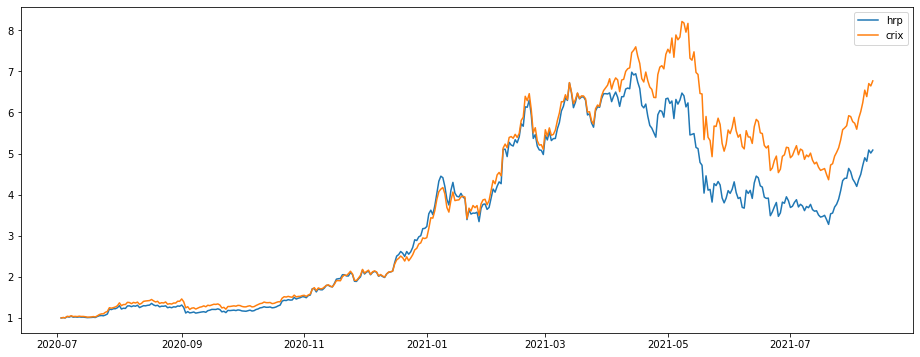

In [108]:
plt.figure(figsize=(16,6))
plt.plot(plot_data['hrp_weight'],label='hrp')
plt.plot(plot_data['CRIX'],label='crix')
plt.legend()